<a href="https://colab.research.google.com/github/jonDuke/GAN_training/blob/main/CIFAR10/GAN_CIFAR10_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More CIFAR10 GAN training

This notebook is my work extending on the tutorial I followed in the first notebook. ([found here](https://github.com/jonDuke/GAN_training/blob/main/CIFAR10/GAN_CIFAR10.ipynb))

The original tutorial just threw all 50,000 images from the training set into a single GAN.  I think I can get better results by training on only one class at a time.

I will also be combining the test images in, since we don't need a test set but we can always use a larger dataset. This adds another 10,000 total images.  

The classes are distributed evenly, so this will give me 6,000 of each class in total.  The real question here is if that will be enough images.  Will the concentrated theme be enough to offset the smaller dataset?

## Loading the data

In [1]:
from keras.datasets.cifar10 import load_data
import numpy as np

# Load the images into memory
(train_X, train_y), (test_X, test_y) = load_data()

images = np.concatenate((train_X, test_X))
classes = np.concatenate((train_y, test_y))

# Summarize the shape of the dataset
# There should be 50k in train and 10k in test
print('Images:', images.shape)

170500096/170498071 [==============================] - 6s 0us/step
Images: (60000, 32, 32, 3)


In [32]:
# Scale data to [-1,1]
images = images.astype('float32')
images = (images - 127.5) / 127.5

In [2]:
# The Keras library just stores classes as numbers, here's the actual labels
class_labels = {
    0: 'airplane',
    1: 'automobile', 
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

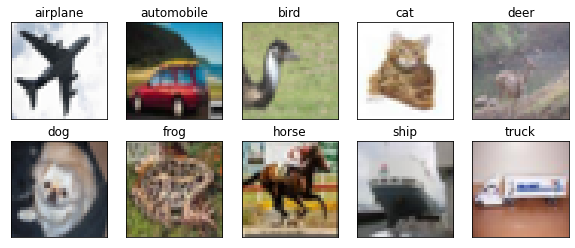

In [3]:
# Plot a random image from each class
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,4))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])  # get the pyplot axis for this image
    all_class = np.where(classes[:]==i)[0]  # get all images of this label
    img_num = np.random.choice(all_class)   # get a random image from that list
    ax.set_title(class_labels[i])           # set title to class label
    plt.imshow(images[img_num])             # show the image
plt.show()

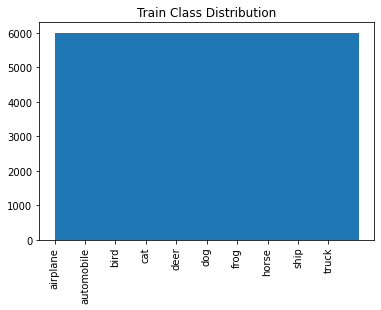

In [4]:
# Class distribution  (exactly 6000 images of each class)
plt.hist(classes, bins=range(0,11))
plt.title("Train Class Distribution")
plt.xticks(ticks=range(0,10), labels=list(class_labels.values()), rotation=90)
plt.show()

# Set up the model

Everything in this section is the same as the previous notebook.  The model structure is exactly the same, so we can see the difference made by a smaller and more refined dataset.

In [5]:
from numpy import expand_dims, ones, zeros
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2D, Flatten, Dropout, LeakyReLU, Conv2DTranspose

In [6]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# View the model summary
define_discriminator().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

In [7]:
# Define the generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# View the model summary
define_generator(100).summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)      

In [8]:
# define the combined generator and discriminator model
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [23]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [10]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch, n=5)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [51]:
# train the GAN together
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128, 
          summary_batches=10, summary_epochs=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch (every [summary_batches] batches)
            if j % summary_batches == 0:
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, every [summary_epochs] epochs
        if (i+1) % summary_epochs == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

# Training the model

This should run a good deal faster since the dataset is only 1/10th the size as before.

In [33]:
# Select the images to train on
class_filter = np.where(classes[:]==3)[0]  # 3 == 'cat'
dataset = images[class_filter]
dataset.shape

(6000, 32, 32, 3)

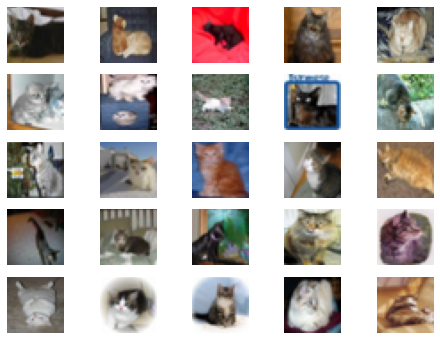

In [36]:
# plot example images from the chosen dataset (visual proof the filter works)
plt.figure(figsize=(8,6))
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # get data and scale to [0,1]
    img = dataset[i]
    img = (img + 1) / 2
    # plot raw pixel data
    plt.imshow(img)

plt.show()

## Train discriminator

In [52]:
# size of the latent space
latent_dim = 100
# create the discriminator and generator
d_model = define_discriminator()
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_26 (Sequential)   (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_25 (Sequential)   (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [53]:
%%time
# train model.  Since we have 1/10th of the data, I am increasing epochs from 200 to 2000.
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2000, summary_epochs=100)

Streaming output truncated to the last 5000 lines.
>1003, 31/46, d1=0.287, d2=0.122 g=3.653
>1003, 41/46, d1=0.270, d2=0.344 g=4.041
>1004, 1/46, d1=0.300, d2=0.145 g=3.848
>1004, 11/46, d1=0.216, d2=0.247 g=3.935
>1004, 21/46, d1=0.400, d2=0.280 g=3.451
>1004, 31/46, d1=0.134, d2=0.164 g=3.475
>1004, 41/46, d1=0.174, d2=0.256 g=3.821
>1005, 1/46, d1=0.205, d2=0.148 g=4.165
>1005, 11/46, d1=0.275, d2=0.208 g=4.194
>1005, 21/46, d1=0.159, d2=0.390 g=3.582
>1005, 31/46, d1=0.159, d2=0.182 g=3.557
>1005, 41/46, d1=0.148, d2=0.099 g=4.071
>1006, 1/46, d1=0.153, d2=0.109 g=3.808
>1006, 11/46, d1=0.161, d2=0.098 g=4.042
>1006, 21/46, d1=0.279, d2=0.118 g=4.118
>1006, 31/46, d1=0.182, d2=0.210 g=4.090
>1006, 41/46, d1=0.124, d2=0.220 g=3.985
>1007, 1/46, d1=0.207, d2=0.142 g=3.754
>1007, 11/46, d1=0.140, d2=0.098 g=4.228
>1007, 21/46, d1=0.258, d2=0.231 g=4.054
>1007, 31/46, d1=0.236, d2=0.179 g=3.484
>1007, 41/46, d1=0.271, d2=0.275 g=4.038
>1008, 1/46, d1=0.328, d2=0.174 g=3.302
>1008, 11/4

And just like last time, use this cell to save the trained model and example images automatically when training is done.

In [54]:
import os
from google.colab import files
from zipfile import ZipFile

# find all .png and .h5 files in the current directory
fnames = [f for f in os.listdir('.') if f.endswith('.png') or f.endswith('.h5')]

# start a zip object and write all found files to it
zipObj = ZipFile('cat_GAN_data.zip', 'w')
for f in fnames:
    zipObj.write(f)

# close the zip file and download it to my local machine
zipObj.close()
files.download('cat_GAN_data.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Results

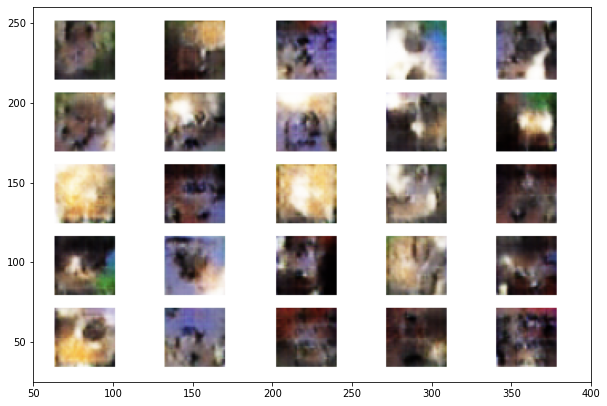

In [55]:
# The checkpoint after only 10 epochs
from matplotlib import image

def plot_image(fname):
    # load image and display it
    data = image.imread(fname)
    plt.figure(figsize=(10,8))
    plt.xlim(50, 400)
    plt.ylim(25, 260)
    plt.imshow(data)
    plt.show()

# The first saved example
plot_image('generated_plot_e100.png')

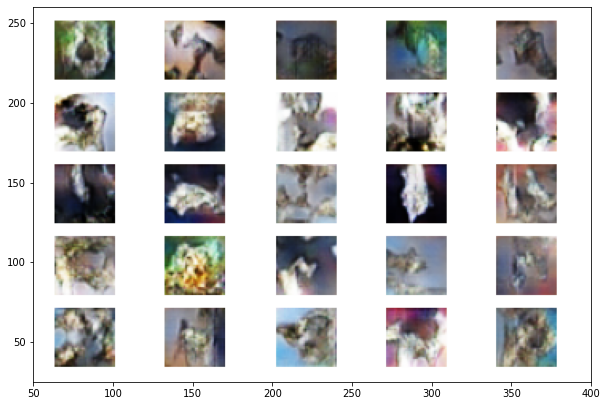

In [56]:
# After 200 epochs (where the original model stopped)
plot_image('generated_plot_e200.png')

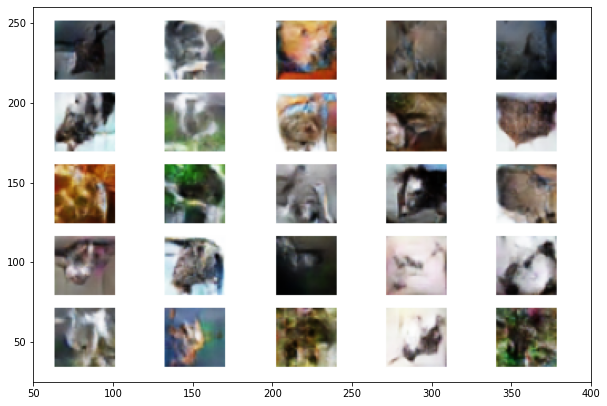

In [57]:
plot_image('generated_plot_e500.png')

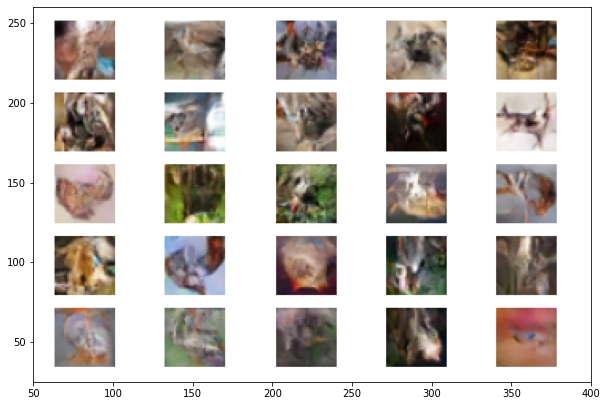

In [58]:
plot_image('generated_plot_e1000.png')

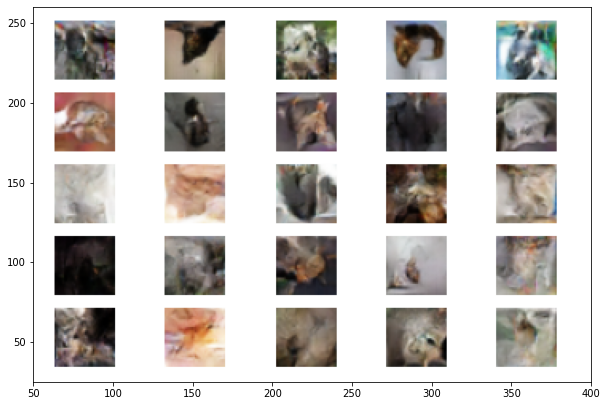

In [59]:
plot_image('generated_plot_e1500.png')

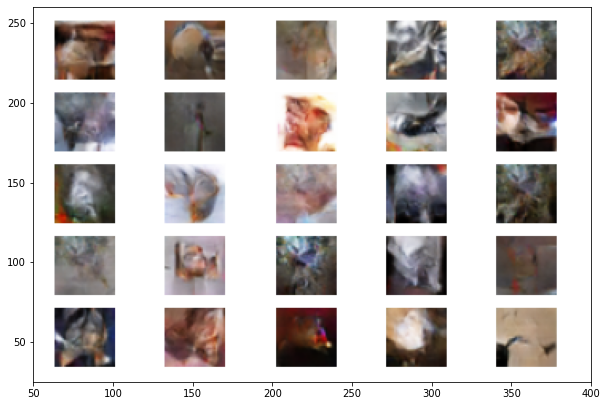

In [60]:
# Final example
plot_image('generated_plot_e2000.png')

## Generate new images with the final trained GAN

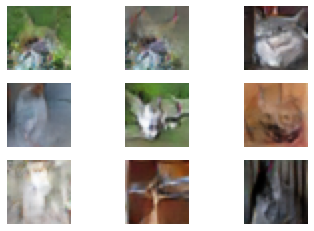

In [65]:
# example of loading the generator model and generating images
from keras.models import load_model
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :])
    plt.show()

# load specified model
model = load_model('generator_model_2000.h5')
# generate images
latent_points = generate_latent_points(100, 9)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 3)

# Conclusion

Overall, I'd say this is about the same quality as I got when using the entire dataset at once.  Which is to say I got some interesting outputs but no convincing pictures of fake cats.  So what would fix it?  Perhaps I need more pictures, or perhaps the model just needed more training?  Is the model itself good enough for this?

Truth is, I don't know the answer yet.  I'll be researching more on this to try and find an answer, but my next project will likely be with a different dataset or model.  We'll see what I find.